In [1]:
import h5py
import numpy as np
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
from utils import transform_coord
from utils import make_grid
from utils import mad_std
from utils import spatial_filter
from utils import interp2d
from utils import tiffread
from utils import binning
from scipy.ndimage.filters import generic_filter

In [2]:
#plot data to view spatial coverage
with h5py.File('/home/jovyan/shared/data-crossovers/Ascending.h5','r') as f_a:
    lat   = f_a['lat'][:]
    lon   = f_a['lon'][:]
    h_elv = f_a['h_elv'][:]
    t_yrs = f_a['t_year'][:]

with h5py.File('/home/jovyan/shared/data-crossovers/Descending.h5','r') as f_b:
    lat2   = f_b['lat'][:]
    lon2   = f_b['lon'][:]
    h_elv2 = f_b['h_elv'][:]
    t_yrs2 = f_b['t_year'][:]


In [3]:
!h5ls /home/jovyan/shared/data-crossovers/Descending.h5

beam                     Dataset {69163}
cycle                    Dataset {69163}
dac                      Dataset {69163}
f_sn                     Dataset {69163}
h_elv                    Dataset {69163}
h_rb                     Dataset {69163}
lat                      Dataset {69163}
lon                      Dataset {69163}
orbit                    Dataset {69163}
q_flg                    Dataset {69163}
rgt                      Dataset {69163}
s_fg                     Dataset {69163}
s_li                     Dataset {69163}
snr                      Dataset {69163}
spot                     Dataset {69163}
t_sec                    Dataset {69163}
t_year                   Dataset {69163}
tide_earth               Dataset {69163}
tide_load                Dataset {69163}
tide_ocean               Dataset {69163}
tide_pole                Dataset {69163}


In [4]:
print(len(lat))
print(len(lon))
print(len(h_elv))

59354
59354
59354


/srv/conda/envs/notebook/lib/python3.7/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/srv/conda/envs/notebook/lib/python3.7/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/srv/conda/envs/notebook/lib/python3.7/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the chang

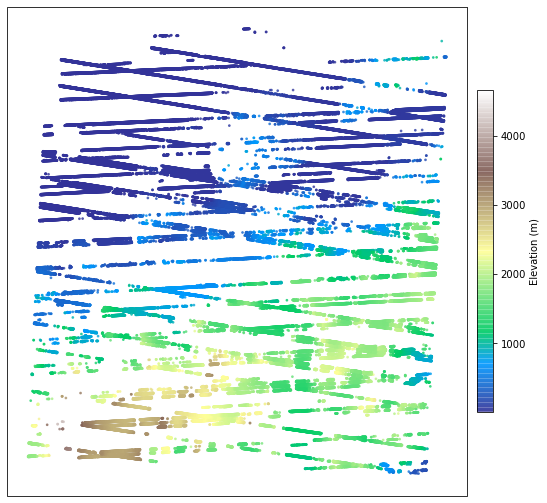

In [5]:
fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection=ccrs.NorthPolarStereo()) #or UTM(7)
lonu, latu = transform_coord('4326', '3413', lon, lat) #transform to polar stereo. To change to UTM, chnage the second argument to 32607
lonu2, latu2 = transform_coord('4326', '3413', lon2, lat2)
plt.scatter(lonu, latu, s=3, c=h_elv, alpha=.7, transform=ccrs.NorthPolarStereo(), cmap='terrain')#or UTM(7)
plt.scatter(lonu2, latu2, s=3, c=h_elv2, alpha=.7, transform=ccrs.NorthPolarStereo(), cmap='terrain')
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation (m)')
ax.coastlines('50m')

In [22]:
!python ./xover.py /home/jovyan/shared/data-crossovers/Ascending.h5 /home/jovyan/shared/data-crossovers/Descending.h5 \
-o ./xoversv2.h5 -r 300 -p 3413 -d 1 -k 1 1 -m linear -v orbit lon lat t_year h_elv dum dum dum -q

parameters:
('input', ['/home/jovyan/shared/data-crossovers/Ascending.h5', '/home/jovyan/shared/data-crossovers/Descending.h5'])
('output', ['./xoversv2.h5'])
('radius', [300.0])
('proj', ['3413'])
('dxy', [1])
('nres', [1, 1])
('buff', [0])
('mode', ['linear'])
('vnames', ['orbit', 'lon', 'lat', 't_year', 'h_elv', 'dum', 'dum', 'dum'])
('tspan', [None, None])
('tile', False)
('plot', True)
('diff', False)
crossing files: /home/jovyan/shared/data-crossovers/Ascending.h5 /home/jovyan/shared/data-crossovers/Descending.h5 ...
tileing asc/des data...
computing crossovers ...

execution time: 0:00:01.011528
number of crossovers found: 354
statistics -> mean: -0.01 std.dev: 0.25 (m) (dt<30d)
statistics -> mean: 0.077 std.dev: 6.944 (dvar/yr)
ofile name -> ./xoversv2.h5
Figure(1200x800)


In [10]:
!h5ls /home/jovyan/shared/data-crossovers/xoversv2.h5 #I'm not sure why this doesn't work

/home/jovyan/shared/data-crossovers/xoversv2.h5: unable to open file


In [130]:
!python xover.py -h

usage: xover.py [-h] [-o ofile] [-r radius] [-p epsg_num] [-d tile_size]
                [-k na nd] [-b buffer] [-m {linear,cubic}]
                [-v o x y t h b l t] [-t t1 t2] [-f] [-q] [-i]
                ifile ifile

Program for computing satellite/airborne crossovers.

positional arguments:
  ifile               name of two input files to cross (HDF5)

optional arguments:
  -h, --help          show this help message and exit
  -o ofile            name of output file (HDF5)
  -r radius           maximum interpolation distance from crossing location
                      (m)
  -p epsg_num         projection: EPSG number (AnIS=3031, GrIS=3413)
  -d tile_size        tile size (km)
  -k na nd            along-track subsampling every k:th pnt for each file
  -b buffer           tile buffer (km)
  -m {linear,cubic}   interpolation method, "linear" or "cubic"
  -v o x y t h b l t  main vars: names if HDF5,
                      orbit/lon/lat/time/height/bs/lew/tes
  -t t1 t2           

In [11]:
with h5py.File('xovers.h5','r') as f_xo:
    lon_xo = f_xo['lon'][:]
    lat_xo = f_xo['lat'][:]
    dh_xo  = f_xo['dh_elv'][:]
    dt_xo  = f_xo['dt_year'][:]

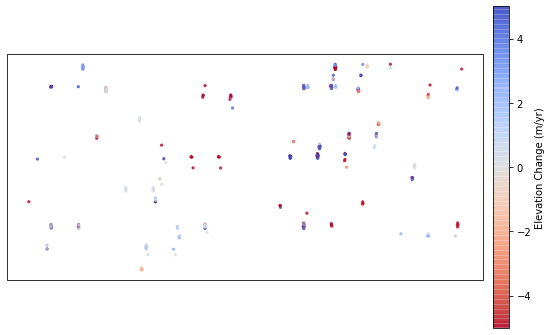

In [53]:
#plot crossovers
fig = plt.figure(figsize=(9,10))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
plt.scatter(lon_xo[abs(dh_xo) <10], lat_xo[abs(dh_xo) <10], s=5,\
            c=dh_xo[abs(dh_xo) <10]/dt_xo[abs(dh_xo) <10], \
            alpha=.7, transform=ccrs.NorthPolarStereo(), cmap='coolwarm_r')
plt.clim([-5.,5.])
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation Change (m/yr)')
#ax.coastlines('50m')

Text(0, 0.5, 'dh')

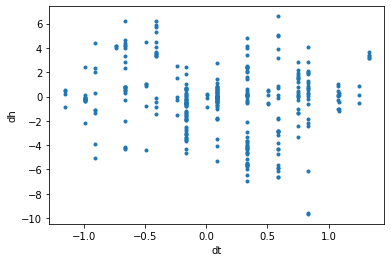

In [55]:
#plot dh vs dt
plt.plot(dt_xo[abs(dh_xo) <10], dh_xo[abs(dh_xo) <10],'.')
plt.xlabel('dt')
plt.ylabel('dh')

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   1.,   1.,   0.,   0.,   4.,   5.,  65., 261.,   7.,
          4.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-176.36307721, -167.67412768, -158.98517815, -150.29622861,
        -141.60727908, -132.91832954, -124.22938001, -115.54043048,
        -106.85148094,  -98.16253141,  -89.47358187,  -80.78463234,
         -72.09568281,  -63.40673327,  -54.71778374,  -46.02883421,
         -37.33988467,  -28.65093514,  -19.9619856 ,  -11.27303607,
          -2.58408654,    6.104863  ,   14.79381253,   23.48276206,
          32.1717116 ,   40.86066113,   49.54961067,   58.2385602 ,
          66.92750973,   75.61645927,   84.3054088 ,   92.99435833,
         101.68330787,  110.3722574 ,  119.06120694,  127.75015647,
         136.439106  ,  145.12805554,  153.817

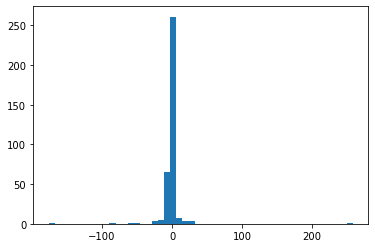

In [14]:
plt.hist(dh_xo, 50)

Trend: -0.57 (m/yr)


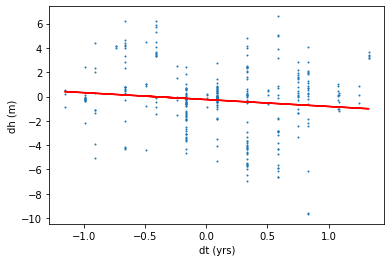

In [56]:
#filter for dh < 10 m and fit a linear trend - we might want to modify this to include just the glacier
plt.plot(dt_xo[np.abs(dh_xo)<10],dh_xo[np.abs(dh_xo)<10],'.',markersize=2)
c_fit = np.polyfit(dt_xo[np.abs(dh_xo)<10], dh_xo[np.abs(dh_xo)<10], 1)
plt.plot(dt_xo[np.abs(dh_xo)<10], np.polyval(c_fit, dt_xo[np.abs(dh_xo)<10]),'r')
plt.ylabel('dh (m)')
plt.xlabel('dt (yrs)')
print('Trend:',np.around(c_fit[0],2),'(m/yr)')

In [57]:
print(len(dt_xo[abs(dh_xo) <10]) #check how many points we're keeping

SyntaxError: unexpected EOF while parsing (<ipython-input-57-39b69affe6d9>, line 1)

In [34]:
i_keep = ((np.abs(dh_xo) < 100) & (np.abs(dt_xo) < 1./12)) #keep height differences < 5m and <30 days

In [35]:
x_xo, y_xo, dt, dh = lon_xo[i_keep], lat_xo[i_keep], dt_xo[i_keep], dh_xo[i_keep]

In [36]:
len(x_xo)

4

(array([ 0.,  0.,  0.,  4., 13.,  9.,  0.,  5., 24.,  0.,  7., 19.,  0.,
         5., 54.,  0.,  4., 52.,  0.,  0., 55.,  0.,  5., 27.,  0., 20.,
        27.,  0.,  0., 16.,  0.,  8.,  0.]),
 array([-17.        , -15.96969697, -14.93939394, -13.90909091,
        -12.87878788, -11.84848485, -10.81818182,  -9.78787879,
         -8.75757576,  -7.72727273,  -6.6969697 ,  -5.66666667,
         -4.63636364,  -3.60606061,  -2.57575758,  -1.54545455,
         -0.51515152,   0.51515152,   1.54545455,   2.57575758,
          3.60606061,   4.63636364,   5.66666667,   6.6969697 ,
          7.72727273,   8.75757576,   9.78787879,  10.81818182,
         11.84848485,  12.87878788,  13.90909091,  14.93939394,
         15.96969697,  17.        ]),
 <a list of 33 Patch objects>)

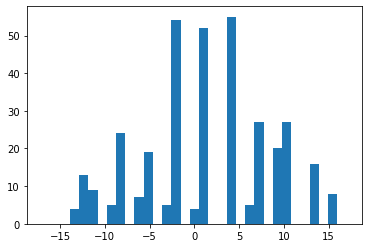

In [46]:
bins_list = np.linspace(-17, 17, 34)
plt.hist(dt_xo*12, bins = bins_list) #should give one bin per month

In [50]:
len(dt_xo[abs(dt_xo*12) <1])

4

The code past this point is for bias analysis. Given that there are so few short-period(<30 days) crossovers, I din't see much point in doing that, unless we feel comfortable using a longer time interval as 'short-period.' Apparently we have very few in the 0-30 day range, but a lot in the 30-60 days range....

Text(0, 0.5, 'Frequency')

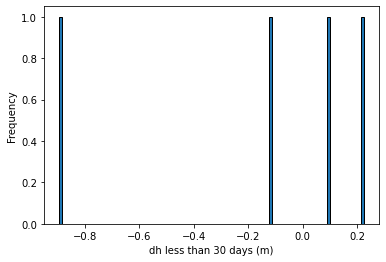

In [20]:
fig = plt.hist(dh[np.abs(dh) < 1.5], 100,edgecolor='k')
plt.xlabel('dh less than 30 days (m)')
plt.ylabel('Frequency')

In [ ]:
print('A/D-Bias:',np.around(np.nanmedian(dh)*100,2), 'cm')
print('Error:',np.around(mad_std(dh)*100,2), 'cm')

In [ ]:
#look at spatial distribution of offset
fig = plt.figure(figsize=(9,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
plt.scatter(lon_xo, lat_xo, s=5,\
            c=dh, \
            alpha=.7, transform=ccrs.PlateCarree(), cmap='coolwarm_r')
plt.clim([-0.5, 0.5]) #modify as needed
plt.colorbar(fraction=0.0320, pad=0.02, label='offset (m)')
ax.coastlines('50m')

In [15]:
Xs, Ys, Zs = tiffread('/home/jovyan/shared/data-crossovers/slope.tif')[0:3]

In [12]:
slope = interp2d(Xs, Ys, Zs, x_xo, y_xo, order=1)

array([[[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       ...,

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0

In [ ]:
slope.min(), slope.max(), slope.mean() #might need to filter first

In [ ]:
slp_b, bias_b, error_b = binning(slope, dh, xmin=0,xmax=40, dx=4, window=4)[0:3] #mess with these parameters

In [ ]:
plt.plot(slp_b, bias_b, '-o')
plt.ylabel('Bias (m)')
plt.xlabel('Slope (deg)')

In [ ]:
plt.plot(slp_b, error_b, '-o')
plt.ylabel('Error (m)')
plt.xlabel('Slope (deg)')

In [18]:
np.nanmax(Zs)

78.24642

(array([[546.,   0.,   0., ...,   0.,   0.,   0.],
        [546.,   0.,   0., ...,   0.,   0.,   0.],
        [543.,   0.,   0., ...,   0.,   0.,   3.],
        ...,
        [546.,   0.,   0., ...,   0.,   0.,   0.],
        [546.,   0.,   0., ...,   0.,   0.,   0.],
        [546.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([-9999.     , -8991.275  , -7983.551  , -6975.826  , -5968.1016 ,
        -4960.377  , -3952.652  , -2944.9275 , -1937.2029 ,  -929.4782 ,
           78.24642], dtype=float32),
 <a list of 546 Lists of Patches objects>)

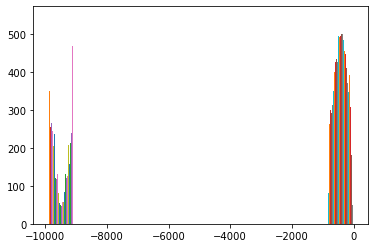

In [19]:
plt.hist(Zs)

(array([9.0318e+04, 3.5024e+04, 2.6318e+04, 2.2624e+04, 1.7196e+04,
        8.2640e+03, 2.0450e+03, 2.1300e+02, 2.3000e+01, 8.0000e+00]),
 array([7.7851611e-04, 7.8253427e+00, 1.5649907e+01, 2.3474472e+01,
        3.1299036e+01, 3.9123600e+01, 4.6948166e+01, 5.4772728e+01,
        6.2597294e+01, 7.0421860e+01, 7.8246422e+01], dtype=float32),
 <a list of 10 Patch objects>)

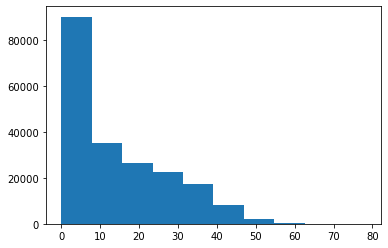

In [24]:
Zs_f = Zs[~np.isnan(Zs)]
plt.hist(Zs_f[Zs_f > -2000])

(array([ 95930.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 202033.]),
 array([-9999.     , -8991.275  , -7983.551  , -6975.826  , -5968.1016 ,
        -4960.377  , -3952.652  , -2944.9275 , -1937.2029 ,  -929.4782 ,
           78.24642], dtype=float32),
 <a list of 10 Patch objects>)

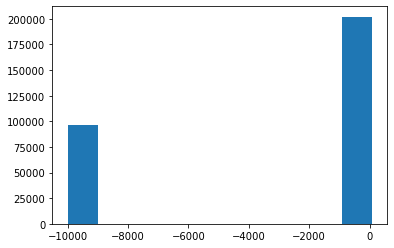

In [25]:
plt.hist(Zs_f)

78.24642

In [69]:
!python fitsec.py /home/jovyan/shared/data-crossovers/Descending.h5 -o ./test.h5 -v lon lat t_year h_elv None None None \
        -m g -d 5 5 -r 2.5 2.5 -a 0.5 -q 2 -z 15 -t 2018 2021 -f fixed -s 1 -p 3 -n 1

parameters:
('files', ['/home/jovyan/shared/data-crossovers/Descending.h5'])
('ofile', ['./test.h5'])
('mode', ['g'])
('bbox', None)
('dxy', [5.0, 5.0])
('radius', [2.5, 2.5])
('resparam', [0.5])
('nreloc', [2])
('niter', [5])
('minobs', [50])
('tspan', [])
('tref', ['fixed'])
('dhdtlim', [15])
('dtlim', [0.1])
('tstep', [1.0])
('idmission', [0])
('residlim', [100])
('projo', ['3031'])
('vnames', ['lon', 'lat', 't_year', 'h_elv', 'None', 'None', 'None'])
('expr', [None])
('njobs', [1])
('model', [3])
running sequential code ...
loading data ...
converting lon/lat to x/y ...
building the k-d tree ...
predicting values ...
saving data ...
**********************************************************************
Mean: 0.85634 Std: 2.80 Min: -12.77 Max: 9.37 Model: 3
**********************************************************************
Execution time: 0:00:40.772019
('Surface fit results ->', './test_sf.h5')
('Time series values -> ', './test_ts.h5')
('Time series errors -> ', './test_es.h5'

In [65]:
!python fitsec.py -h

usage: fitsec.py [-h] [-o outfile] [-m {p,g}] [-b w e s n] [-d dx dy]
                 [-r r_min r_max] [-a res_param] [-q n_reloc] [-i n_iter]
                 [-z min_obs] [-t t_min t_max] [-f ref_time] [-l dhdt_lim]
                 [-k dt_lim] [-s t_step] [-u id_mission] [-w resid_lim]
                 [-j epsg_num] [-v x y t h s i c] [-x expr] [-n njobs]
                 [-p {0,1,2,3}]
                 file [file ...]

Computes robust surface-height changes from satellite/airborne altimetry.

positional arguments:
  file              file(s) to process (ASCII, HDF5 or Numpy)

optional arguments:
  -h, --help        show this help message and exit
  -o outfile        output file name, default same as input
  -m {p,g}          prediction mode: (p)oint or (g)rid
  -b w e s n        bounding box for geograph. region (deg or m)
  -d dx dy          spatial resolution for grid-solution (deg or m)
  -r r_min r_max    min and max search radius (km)
  -a res_param      resolution param for 

In [70]:
pwd

'/home/jovyan/ScienceDataGeneration/notebooks'

In [71]:
!h5ls test_sf.h5


accel                    Dataset {34224}
accel_err                Dataset {34224}
amp_seas                 Dataset {34224}
bias                     Dataset {34224}
chi2                     Dataset {34224}
d_min                    Dataset {34224}
d_ri                     Dataset {34224}
height                   Dataset {34224}
height_err               Dataset {34224}
lat                      Dataset {34224}
lon                      Dataset {34224}
model_rms                Dataset {34224}
n_edited                 Dataset {34224}
n_obs                    Dataset {34224}
pha_seas                 Dataset {34224}
slope_x                  Dataset {34224}
slope_y                  Dataset {34224}
t_ref                    Dataset {34224}
t_span                   Dataset {34224}
trend                    Dataset {34224}
trend_err                Dataset {34224}


In [75]:
f = h5py.File('test_sf.h5', "r")

In [78]:
dh_dt = f['trend'][:]
lat = f['lat'][:]
lon = f['lon'][:]

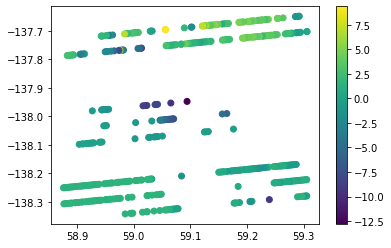

In [81]:
plt.scatter(lat, lon, c = dh_dt)
plt.colorbar()

In [83]:
f2 = h5py.File('test_ts.h5', 'r')

In [86]:
f2.keys()


<KeysViewHDF5 ['ts']>

In [88]:
ts = f2['ts'][:]

In [90]:
ts.shape

(34224, 23)

In [100]:
latitude = ts[]

In [102]:
latitude[~np.isnan(latitude)]

array([59.30542494, 59.30423615, 59.30188921, 59.29971546, 59.29722687,
       59.29360995, 59.28915824, 59.30547889, 59.30470718, 59.30291708,
       59.29997658, 59.29791961, 59.29546225, 59.29331596, 59.29094306,
       59.28856589, 59.286294  , 59.28397579, 59.28164618, 59.27946517,
       59.27709748, 59.27481534, 59.27246416, 59.27025047, 59.26784133,
       59.23942242, 59.26319267, 59.26077184, 59.28690209, 59.2585401 ,
       59.25619587, 59.28240743, 59.27990311, 59.25391595, 59.25153102,
       59.27775713, 59.27527622, 59.24940136, 59.24776246, 59.27310673,
       59.27069217, 59.26847684, 59.26622302, 59.20883197, 59.2639607 ,
       59.26135251, 59.20676068, 59.20516362, 59.2593046 , 59.25728125,
       59.25182998, 59.25015202, 59.24731   , 59.18678373, 59.23829345,
       59.18132791, 59.17870823, 59.23343049, 59.17716683, 59.22911858,
       59.22444929, 59.22205114, 59.219822  , 59.21751917, 59.21541136,
       59.21282391, 59.18424503, 59.21048695, 59.20823418, 59.20

In [103]:
time_series = ts[:, 6:]

In [104]:
time_series.shape

(34224, 17)

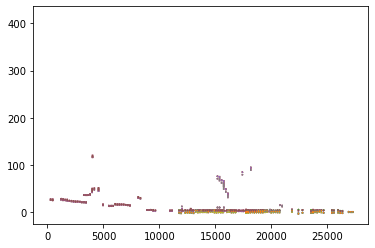

In [107]:
plt.plot(time_series)

In [117]:
help(transform_coord)

Help on function transform_coord in module utils:

transform_coord(proj1, proj2, x, y)
    Transform coordinates from proj1 to proj2
    usgin EPSG number
    
    :param proj1: current projection (4326)
    :param proj2: target projection (3031)
    :param x: x-coord in current proj1
    :param y: y-coord in current proj1
    :return: x and y now in proj2

